## DBCV (Density-Based Clustering Validation)

In [5]:
from itertools import combinations

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_moons

from scipy.stats import multivariate_normal
from scipy.spatial.distance import pdist, squareform
import igraph as ig

import hdbscan
import hdbscan.validity
from kneed import KneeLocator

sns.set_theme()
plt.rcParams["image.cmap"] = "tab10"


## Create the Dataset 

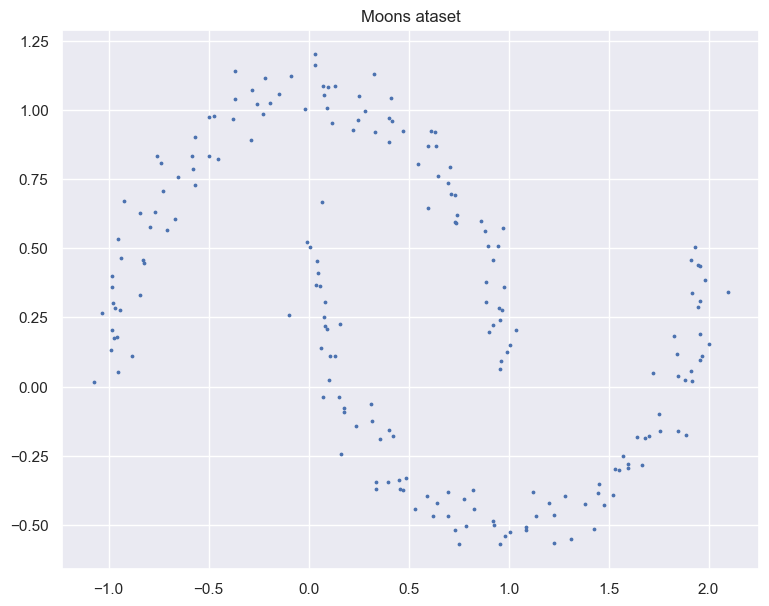

In [ ]:
# Create moon dataset
X, y = make_moons(n_samples=200,  shuffle=True, noise=0.06, random_state=12)
X[:,1][y==0] += 0.05

# Plot moon dataset 
plt.figure(figsize=(9,7)) 
plt.scatter(X[:, 0], X[:, 1], s=3)
plt.title('Moons ataset')
plt.show()

In [7]:
# Cluster moons with k-means
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans = kmeans.fit(X)

In [8]:
CLR_DCT = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    -1:'black'
}

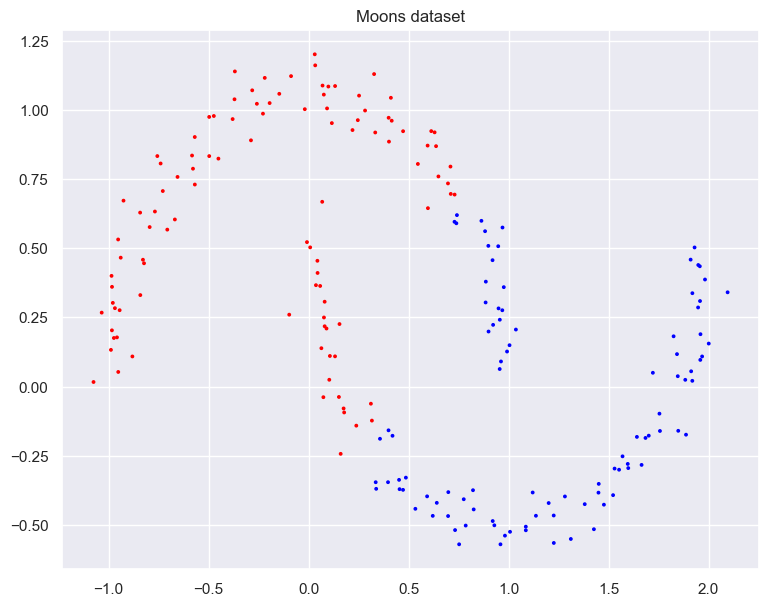

In [9]:
# Plot moon dataset
plt.figure(figsize=(9,7))
point_colors = [CLR_DCT[label] for label in kmeans.labels_]
plt.scatter(X[:, 0], X[:, 1], s=3, c=point_colors)
plt.title('Moons dataset')
plt.show()

In [10]:
silhouette_score(X, kmeans.labels_)

0.48316586739307915

In [11]:
np.meshgrid([2,4,6], [2,4,6])

[array([[2, 4, 6],
        [2, 4, 6],
        [2, 4, 6]]),
 array([[2, 2, 2],
        [4, 4, 4],
        [6, 6, 6]])]

In [12]:
pd.DataFrame(np.max(np.meshgrid([2,4,6], [2,4,6]), axis=0))

,0,1,2
0,2,4,6
1,4,4,6
2,6,6,6


In [13]:
## DBCV 

In [14]:
# Get dbscan labels
labels = kmeans.labels_

# Choose metric
DIST_FUNCTION = "euclidean"
NUM_FEATURES = 2
IGNORE_CORE = False

# Check if distance function is precomputed
if DIST_FUNCTION == "precomputed":
    n_samples = np.shape(X)[0]
    n_features = DIST_FUNCTION
    dists = X
else:
    n_samples = np.shape(X)[0]
    n_features = np.shape(X)[1]
    dists = pdist(X, DIST_FUNCTION)
    dists = squareform(dists)

It Calculates pairwise distances based on the chosen distance metric (`DIST_FUNCTION`) and the dataset `X`. It also checks if the distance matrix is precomputed or needs to be computed. 

---


#### 1. **Get `kmeans.labels_`**
```python
labels = kmeans.labels_
```
- This retrieves the cluster labels assigned to each data point by the K-Means algorithm (`kmeans` object). 
- These labels indicate which cluster each data point belongs to.

---

#### 2. **Define Parameters**
```python
DIST_FUNCTION = "euclidean"
NUM_FEATURES = 2
IGNORE_CORE = False
```
- `DIST_FUNCTION`: Specifies the distance metric for calculating pairwise distances between points. In this case, it's set to `"euclidean"`.
- `NUM_FEATURES`: Assumes 2-dimensional data by default.
- `IGNORE_CORE`: May be a flag used later to determine if core points should be ignored in subsequent clustering logic.

---

#### 3. **Check if Distance Function is Precomputed**
```python
if DIST_FUNCTION == "precomputed":
    n_samples = np.shape(X)[0]
    n_features = DIST_FUNCTION
    dists = X
```
- If the distance matrix is already precomputed:
  - `n_samples`: The number of samples in the dataset (`X`).
  - `n_features`: Stores the distance function's name (`precomputed`).
  - `dists`: Uses the provided matrix `X` directly as the distance matrix.

---

#### 4. **Calculate Distance Matrix**
```python
else:
    n_samples = np.shape(X)[0]
    n_features = np.shape(X)[1]
    dists = pdist(X, DIST_FUNCTION)
    dists = squareform(dists)
```
- If the distance matrix is not precomputed:
  - `n_samples`: Number of data points (`rows` in `X`).
  - `n_features`: Number of features per data point (`columns` in `X`).
  - `pdist(X, DIST_FUNCTION)`: Computes the pairwise distances between all points in `X` using the specified metric (e.g., "euclidean").
  - `squareform(dists)`: Converts the condensed distance matrix from `pdist` into a square form (a full pairwise distance matrix).

---

In [15]:
# Core distance calculation

# Array that will be used to store core distances
core_dists = np.empty(n_samples)

# Dict for cluster index
clust_point_dict = {}

# Get all unique clusters
unique_clusts = list(np.unique(labels))
unique_clusts = [clust for clust in unique_clusts if clust!=-1]

if not IGNORE_CORE:

    # Iterate through unique labels - all calculations
    # in a single loop iteration correspond to single cluster
    for label in unique_clusts:
        
        # Get mask corresponding only to
        # datapoints from current cluster
        clust_ids = np.where(labels==label)[0]

        # Add all cluster points to dict
        clust_point_dict[label] = clust_ids

        # Get number of points for cluster
        num_clust_points = clust_ids.shape[0]

        # Calculate core distances based on distances to
        # nearest neighbors
        clust_core_dists = dists[np.ix_(clust_ids, clust_ids)]

        clust_core_dists[clust_core_dists != 0] = np.power(
            clust_core_dists[clust_core_dists != 0],
            -n_features
        )

        clust_core_dists = np.sum(clust_core_dists, axis=1)/(num_clust_points - 1)
        clust_core_dists = np.power(clust_core_dists, -1/n_features)

        # Store core dists
        core_dists[clust_ids] = clust_core_dists

        
    # Create mutual reachibility distance matrix
    max_core_dist = np.max(
        np.meshgrid(core_dists, core_dists), 
        axis=0
    )
    
    mut_reach_dist = np.max(
        [dists, max_core_dist], 
        axis=0
    )
    
else:
    
    for label in unique_clusts:
        
        clust_ids = np.where(labels==label)[0]
    
        clust_point_dict[label] = clust_ids

    mut_reach_dist = dists

This code calculates **core distances** and creates a **mutual reachability distance matrix** for clustering. 
---


1. **Core Distance**:
   - The minimum distance a point needs to have to its nearest neighbors for it to be considered a "core point" in clustering (e.g., DBSCAN or HDBSCAN).

2. **Mutual Reachability Distance**:
   - A distance measure that considers both the core distances and the pairwise distances between points. It's often used in hierarchical clustering algorithms like HDBSCAN.

---

### **Code Walkthrough**

#### **1. Initialization**
```python
core_dists = np.empty(n_samples)
clust_point_dict = {}
unique_clusts = list(np.unique(labels))
unique_clusts = [clust for clust in unique_clusts if clust != -1]
```
- `core_dists`: Array to store core distances for each point.
- `clust_point_dict`: Dictionary to map cluster labels to the indices of points in that cluster.
- `unique_clusts`: List of all unique clusters in the dataset, excluding noise (`label = -1`).

---

#### **2. Core Distance Calculation**
If `IGNORE_CORE` is `False`, the core distances are calculated:

```python
for label in unique_clusts:
    clust_ids = np.where(labels == label)[0]
    clust_point_dict[label] = clust_ids
    num_clust_points = clust_ids.shape[0]
```
- Loop through each cluster (`label`) and extract the indices (`clust_ids`) of points in that cluster.
- Store the cluster points in `clust_point_dict`.

---

**Distance Matrix for Cluster**
```python
clust_core_dists = dists[np.ix_(clust_ids, clust_ids)]
```
- Extract pairwise distances (`clust_core_dists`) for points in the current cluster using `np.ix_`.

---

**Transform Distances**
```python
clust_core_dists[clust_core_dists != 0] = np.power(
    clust_core_dists[clust_core_dists != 0], 
    -n_features
)
```
- Invert non-zero distances by raising them to the power of `-n_features`. This scales the distances, often for compatibility with the chosen clustering metric.

---

**Aggregate Core Distances**
```python
clust_core_dists = np.sum(clust_core_dists, axis=1) / (num_clust_points - 1)
clust_core_dists = np.power(clust_core_dists, -1 / n_features)
core_dists[clust_ids] = clust_core_dists
```
- Compute the core distance for each point by averaging the inverted distances of its neighbors, adjusting for the cluster size.
- Store these core distances in `core_dists`.

---

#### **3. Mutual Reachability Distance**
```python
max_core_dist = np.max(
    np.meshgrid(core_dists, core_dists), 
    axis=0
)
mut_reach_dist = np.max(
    [dists, max_core_dist], 
    axis=0
)
```
- **`max_core_dist`**: Pairwise maximum of core distances between two points.
- **`mut_reach_dist`**: The maximum of the pairwise distance (`dists`) and the maximum core distance.

This ensures that the distance between two points is influenced by their respective core distances.

---

#### **4. Handling `IGNORE_CORE`**
```python
else:
    for label in unique_clusts:
        clust_ids = np.where(labels == label)[0]
        clust_point_dict[label] = clust_ids
    mut_reach_dist = dists
```
- If `IGNORE_CORE` is `True`, core distances are skipped, and the mutual reachability distance is just the pairwise distance matrix (`dists`).

---



In [17]:
# Cluster density sparseness

# Dict to store density sparseness of a cluster
cluster_dens_spars = {}

# Dict to store cluster internal nodes
cluster_internal_nodes = {}

# In this loop sparseness of a cluster and 
# internal nodes are obtained
for label in unique_clusts:
        
    # Get index of all points from current cluster
    point_idx = clust_point_dict[label]
    
    # Get reachibility distances for points in
    # current cluster
    clust_mut_reach_dist = mut_reach_dist[np.ix_(point_idx, point_idx)].copy()
    np.fill_diagonal(clust_mut_reach_dist, 0)
        
    g = ig.Graph.Weighted_Adjacency(clust_mut_reach_dist, mode='undirected')

    # Find the minimum spanning tree
    mst = g.spanning_tree(weights=g.es["weight"])

    mst_adj = mst.get_adjacency(attribute='weight')
    curr_MST = np.array(mst_adj.data)
    
    # Calculate node degree
    node_degree = np.array((curr_MST>0).sum(axis=0)).flatten()
    
    # Find index of all internal nodes
    # (nodes with degree greater than 1)
    intern_sub_idx = np.where(node_degree>1)[0]
    
    # Max edge weight in MST is density sparseness of a cluster
    # Max edge is taken from set of internal edges
    cluster_dens_spars[label] = (curr_MST[np.ix_(intern_sub_idx,intern_sub_idx)]).max()
        
    # Collect all internal nodes of a cluster
    cluster_internal_nodes[label] = point_idx[intern_sub_idx]

This code calculates the **density sparseness** of clusters and identifies their **internal nodes** using graph-theoretic methods. 

---

1. **Density Sparseness**:
   - The maximum edge weight (distance) among the internal nodes of the minimum spanning tree (MST) of a cluster. It reflects the "sparsest" connection in the densest part of the cluster.

2. **Internal Nodes**:
   - Nodes in the MST with a degree (number of connections) greater than 1. These nodes are central to the cluster's structure.

3. **Minimum Spanning Tree (MST)**:
   - A subset of the graph that connects all nodes with the minimum possible total edge weight and without cycles.

---

### **Code Explanation**

#### **1. Initialization**
```python
cluster_dens_spars = {}
cluster_internal_nodes = {}
```
- **`cluster_dens_spars`**: Dictionary to store the density sparseness for each cluster.
- **`cluster_internal_nodes`**: Dictionary to store the internal nodes for each cluster.

---

#### **2. Loop Through Clusters**
```python
for label in unique_clusts:
    point_idx = clust_point_dict[label]
    clust_mut_reach_dist = mut_reach_dist[np.ix_(point_idx, point_idx)].copy()
    np.fill_diagonal(clust_mut_reach_dist, 0)
```
- **`point_idx`**: Indices of all points belonging to the current cluster.
- **`clust_mut_reach_dist`**: Sub-matrix of the mutual reachability distance matrix for the current cluster.
- **`np.fill_diagonal(clust_mut_reach_dist, 0)`**: Set the diagonal to 0 because the distance of a point to itself is 0.

---

#### **3. Create Graph and MST**
```python
g = ig.Graph.Weighted_Adjacency(clust_mut_reach_dist, mode='undirected')
mst = g.spanning_tree(weights=g.es["weight"])
```
- **`Graph.Weighted_Adjacency`**: Create a weighted undirected graph using the adjacency matrix (`clust_mut_reach_dist`).
- **`spanning_tree`**: Compute the MST for the graph using edge weights.

---

#### **4. MST Adjacency Matrix**
```python
mst_adj = mst.get_adjacency(attribute='weight')
curr_MST = np.array(mst_adj.data)
```
- **`mst.get_adjacency(attribute='weight')`**: Get the adjacency matrix of the MST, where weights represent edge distances.
- **`curr_MST`**: Convert the adjacency matrix into a NumPy array.

---

#### **5. Node Degree**
```python
node_degree = np.array((curr_MST > 0).sum(axis=0)).flatten()
intern_sub_idx = np.where(node_degree > 1)[0]
```
- **`node_degree`**: Calculate the degree of each node (number of connections) in the MST.
- **`intern_sub_idx`**: Identify internal nodes (nodes with a degree greater than 1).

---

#### **6. Density Sparseness**
```python
cluster_dens_spars[label] = (curr_MST[np.ix_(intern_sub_idx, intern_sub_idx)]).max()
```
- Extract the submatrix of the MST for internal nodes.
- Find the maximum edge weight in this submatrix, which represents the **density sparseness** of the cluster.

---

#### **7. Internal Nodes**
```python
cluster_internal_nodes[label] = point_idx[intern_sub_idx]
```
- Map the indices of internal nodes back to their original data indices (`point_idx`).

---

### **Purpose**
The output of this code provides:
1. **`cluster_dens_spars`**: The maximum "weakness" in the cluster structure, representing how sparse the densest part of the cluster is.
2. **`cluster_internal_nodes`**: The set of internal nodes in each cluster, which are critical for understanding the core structure of the cluster.


In [18]:
cluster_dens_spars

{0: 0.4476775404345504, 1: 0.45776262472976065}

In [19]:
# Cluster density separation

# Get all cluster pairs
clust_combs = list(combinations(unique_clusts, 2))

# Dataframe to store density separation
# between cluster pairs
distance_df = pd.DataFrame(
    np.full([len(unique_clusts), len(unique_clusts)], 0), 
    index=unique_clusts, 
    columns=unique_clusts)

# Calculate density separation for 
# cluster pairs
for clust_comb in clust_combs:
    
    # Get cluster ids
    clust1 = clust_comb[0]
    clust2 = clust_comb[1]
    
    # Get cluster internal nodes
    clust1_points = cluster_internal_nodes[clust1]
    clust2_points = cluster_internal_nodes[clust2]
    
    # Minimum reachability between clsuter internal nodes
    # is cluster density separation
    curr_clust_sep = (mut_reach_dist[np.ix_(clust2_points, clust1_points)]).min()
    
    # Write distance to symetrical distance matrix
    distance_df.loc[clust1, clust2] = curr_clust_sep
    distance_df.loc[clust2, clust1] = curr_clust_sep
    

/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_4430/563430465.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16386000548281546' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  distance_df.loc[clust1, clust2] = curr_clust_sep
/var/folders/h2/hlt0n3hj3jx4phv5m7ncq2180000gn/T/ipykernel_4430/563430465.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16386000548281546' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  distance_df.loc[clust2, clust1] = curr_clust_sep


This code calculates the **density separation** between pairs of clusters and stores it in a symmetrical distance matrix. Density separation quantifies how separate two clusters are based on the minimum **mutual reachability distance** between their internal nodes.

---


#### **1. Cluster Pair Combinations**
```python
clust_combs = list(combinations(unique_clusts, 2))
```
- **`combinations(unique_clusts, 2)`**: Generates all possible unique pairs of clusters. 
- Example: If there are 3 clusters `[A, B, C]`, the pairs would be `[(A, B), (A, C), (B, C)]`.

---

#### **2. Initialize Dataframe**
```python
distance_df = pd.DataFrame(
    np.full([len(unique_clusts), len(unique_clusts)], 0), 
    index=unique_clusts, 
    columns=unique_clusts)
```
- A symmetric matrix (stored as a DataFrame) to represent the density separation between each cluster pair.
- Initially, all values are set to 0.
- Rows and columns correspond to the unique cluster labels.

---

#### **3. Iterate Through Cluster Pairs**
```python
for clust_comb in clust_combs:
    clust1 = clust_comb[0]
    clust2 = clust_comb[1]
```
- Loop over all cluster pairs (`clust_combs`).
- For each pair, extract the cluster labels (`clust1`, `clust2`).

---

#### **4. Extract Internal Nodes**
```python
clust1_points = cluster_internal_nodes[clust1]
clust2_points = cluster_internal_nodes[clust2]
```
- Retrieve the internal nodes for each cluster from the `cluster_internal_nodes` dictionary.

---

#### **5. Calculate Density Separation**
```python
curr_clust_sep = (mut_reach_dist[np.ix_(clust2_points, clust1_points)]).min()
```
- Extract the submatrix of the mutual reachability distance (`mut_reach_dist`) between the internal nodes of the two clusters.
- Find the **minimum** value in this submatrix (`curr_clust_sep`). This represents the **density separation** between the clusters.
  - Smaller values indicate closer clusters.
  - Larger values indicate well-separated clusters.

---

#### **6. Update Symmetric Matrix**
```python
distance_df.loc[clust1, clust2] = curr_clust_sep
distance_df.loc[clust2, clust1] = curr_clust_sep
```
- Update the density separation for the cluster pair in the symmetric matrix.
- Both `[clust1, clust2]` and `[clust2, clust1]` are updated to ensure symmetry.

---

### **Output**

#### **`distance_df`**
The resulting `distance_df` is a symmetric DataFrame where:
- Rows and columns correspond to unique cluster labels.
- Values represent the **density separation** between the clusters.


In [20]:
distance_df

,0,1
0,0.00000,0.16386
1,0.16386,0.00000


In [21]:
# Calculate validity coefficient for all clusters
cluster_vc = {}

for label in unique_clusts:
    
    curr_vc_nom = distance_df[label].max() - cluster_dens_spars[label]
    curr_vc_den = max(distance_df[label].max(), cluster_dens_spars[label])
    
    cluster_vc[label] = curr_vc_nom/curr_vc_den
    

# Final calculation
final_res = 0

for label in unique_clusts:
    
    final_res +=  cluster_vc[label] * (clust_point_dict[label].shape[0]/n_samples)
    print('Validity index for cluster {} is {}'.format(label, cluster_vc[label]))
    
print('Mean validity index is {}'.format(final_res))

Validity index for cluster 0 is -0.6339776051222934
Validity index for cluster 1 is -0.6420415371841466
Mean validity index is -0.6378886121722922


This code calculates the **validity coefficient** for each cluster and computes the **mean validity index** for the entire dataset. The validity index is a measure that evaluates the quality of clustering based on the relationship between **cluster density sparseness** and **cluster density separation**.

---


#### **1. Validity Coefficient Calculation for Each Cluster**
```python
cluster_vc = {}
```
- A dictionary to store the **validity coefficient** for each cluster.

##### Loop Over Each Cluster
```python
for label in unique_clusts:
```
- Iterate through each unique cluster.

##### Calculate Validity Coefficient
```python
curr_vc_nom = distance_df[label].max() - cluster_dens_spars[label]
curr_vc_den = max(distance_df[label].max(), cluster_dens_spars[label])
cluster_vc[label] = curr_vc_nom / curr_vc_den
```
- **Numerator (`curr_vc_nom`)**: 
  - The difference between the maximum density separation (`distance_df[label].max()`) and the cluster's density sparseness (`cluster_dens_spars[label]`).
  - Indicates how distinct the cluster is compared to its neighbors.
- **Denominator (`curr_vc_den`)**: 
  - The larger of the two values: maximum density separation or cluster density sparseness.
  - Normalizes the validity coefficient to be in the range [0, 1].
- **Validity Coefficient (`cluster_vc[label]`)**: 
  - A ratio representing the quality of the cluster.
  - Higher values indicate better-defined clusters (well-separated and dense).

---

#### **2. Final Validity Index Calculation**
```python
final_res = 0
```
- Initialize the cumulative **mean validity index**.

##### Loop Through Clusters
```python
for label in unique_clusts:
    final_res += cluster_vc[label] * (clust_point_dict[label].shape[0] / n_samples)
```
- Compute the weighted sum of cluster validity coefficients.
- Weight for each cluster is proportional to the number of points in the cluster (`clust_point_dict[label].shape[0] / n_samples`).

##### Print Cluster-Level Validity Index
```python
print('Validity index for cluster {} is {}'.format(label, cluster_vc[label]))
```
- Output the validity coefficient for each cluster.

---

#### **3. Mean Validity Index**
```python
print('Mean validity index is {}'.format(final_res))
```
- The **mean validity index** represents the overall quality of the clustering.
  - A higher mean validity index indicates better clustering performance.

---

In [22]:
# HDBSCAN libraru validity index
hdbscan.validity.validity_index(
    X=X, 
    labels=kmeans.labels_, 
    metric='euclidean', 
    per_cluster_scores=True
)

(-0.621261644612346, array([-0.61717106, -0.62560526]))

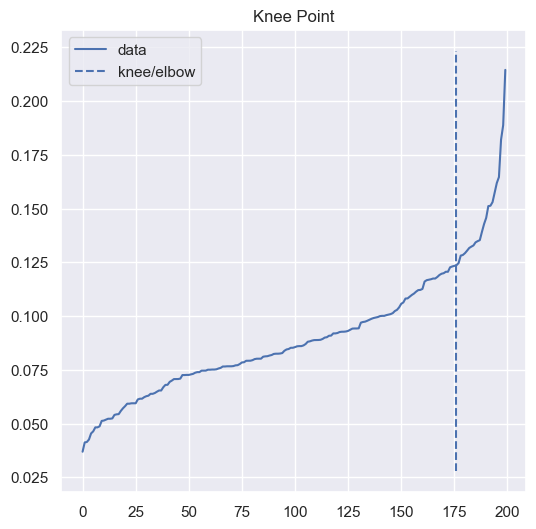

In [23]:
min_pts = X.shape[1] * 2

nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X)
distances, _ = nbrs.kneighbors(X)

sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]), 
    sort_dist, 
    S=1.0, 
    curve="convex", 
    direction="increasing"
)
kneedle.plot_knee()

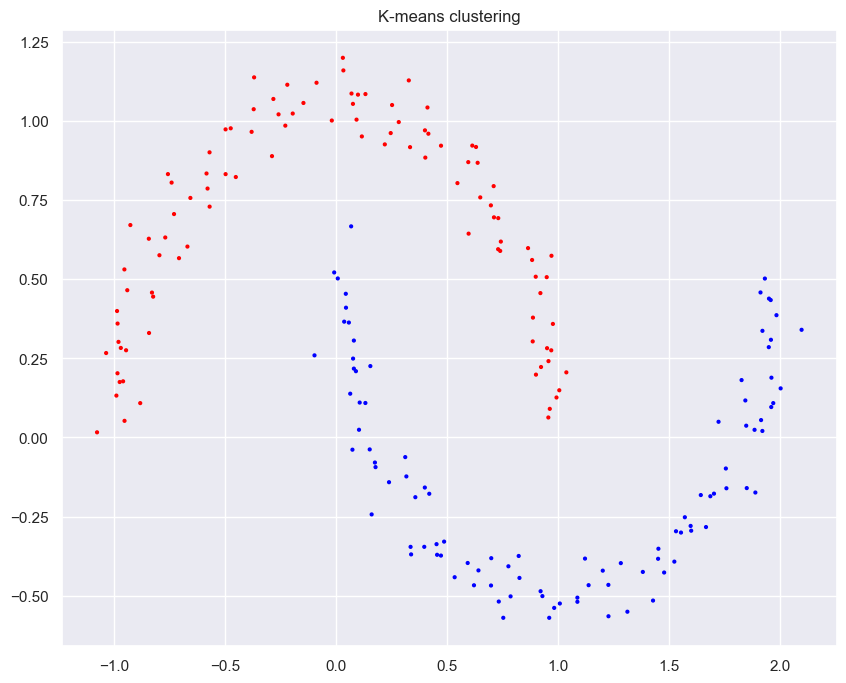

In [24]:
dbscan = DBSCAN(eps=0.175, min_samples=4)
_ = dbscan.fit(X)


colors = [CLR_DCT[label] for label in dbscan.labels_]

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=4, c=colors)
plt.title('K-means clustering')
plt.show()


In [25]:
hdbscan.validity.validity_index(
    X=X, 
    labels=dbscan.labels_, 
    metric='euclidean', 
    per_cluster_scores=True
)

(0.3509077355512182, array([0.27067122, 0.43114425]))

## Parallel And Long Clusters 

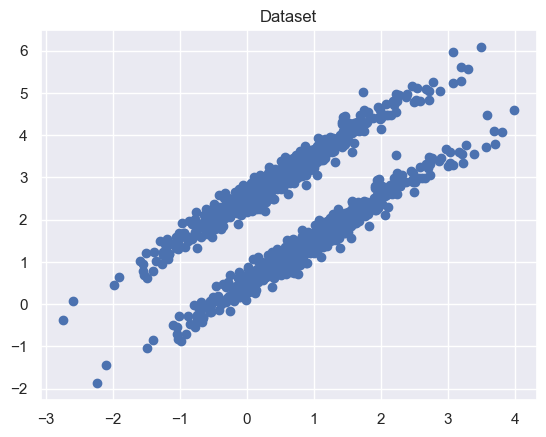

In [26]:
# Create elongated clusters
multivar = multivariate_normal(cov = [[1, 0.98],[0.98,1]], mean = [1,1.5])
X1 = multivar.rvs(size = 500, random_state=1)

multivar = multivariate_normal(cov = [[1, 0.98],[0.98,1]], mean = [0.5,3])
X2 = multivar.rvs(size = 500, random_state=1)

X = np.vstack([X1, X2])

# Plot new clustering
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.title('Dataset')
plt.show()

The code generates two elongated Gaussian clusters with strong positive correlation between their dimensions. 
---


#### **1. Generate First Cluster (`X1`)**
```python
multivar = multivariate_normal(cov=[[1, 0.98], [0.98, 1]], mean=[1, 1.5])
X1 = multivar.rvs(size=500, random_state=1)
```
- **Covariance Matrix (`cov`)**:
  - Defines the shape and orientation of the cluster.
  - `[[1, 0.98], [0.98, 1]]` indicates:
    - Variance of 1 along both dimensions.
    - A high correlation of 0.98 between the dimensions, creating an elongated structure.
- **Mean (`mean`)**: `[1, 1.5]` centers the cluster around (1, 1.5).
- **Random Variates (`rvs`)**: Generates 500 data points with the specified distribution.

---

#### **2. Generate Second Cluster (`X2`)**
```python
multivar = multivariate_normal(cov=[[1, 0.98], [0.98, 1]], mean=[0.5, 3])
X2 = multivar.rvs(size=500, random_state=1)
```
- Similar to `X1`, but centered at `[0.5, 3]`.

---

#### **3. Combine Clusters**
```python
X = np.vstack([X1, X2])
```
- Vertically stacks `X1` and `X2` to form a single dataset.

---

#### **4. Plot the Dataset**

```python
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.title('Dataset')
plt.show()
```
- Creates a scatter plot of the combined dataset.
- Highlights the elongated and correlated nature of the clusters.

---

### **Expected Plot**
The plot should display:
1. Two elongated clusters, one centered around (1, 1.5) and the other around (0.5, 3).
2. Each cluster will be oriented diagonally due to the high correlation (0.98) between dimensions.

---


In [27]:
X

array([[-0.55502759, -0.17737887],
       [ 1.63282112,  1.9182274 ],
       [ 0.36908415,  0.40877641],
       ...,
       [-0.77307232,  1.70363885],
       [ 2.77284535,  5.25892044],
       [ 0.16659887,  2.62920787]])

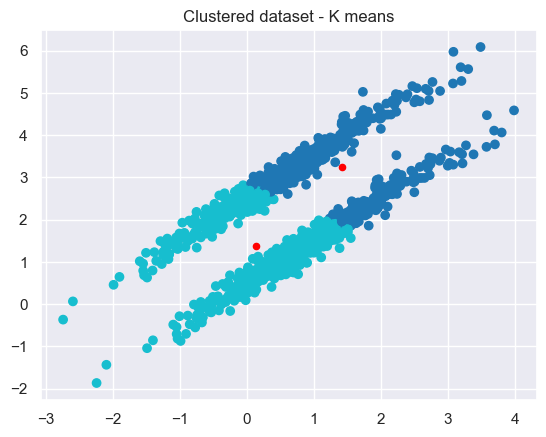

In [28]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
kmeans.fit(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='red')
plt.title('Clustered dataset - K means')
plt.show()

This code applies the **K-Means clustering algorithm** to the elongated dataset and visualizes the results.

#### **1. Initialize K-Means**
```python
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')
```
- **`n_clusters=2`**:
  - Specifies the number of clusters to identify (aligned with the two true clusters in the data).
- **`random_state=0`**:
  - Ensures reproducibility of the cluster assignments.
- **`n_init='auto'`**:
  - Automatically sets the initialization method. In modern versions of scikit-learn, this defaults to an optimized configuration.

---

#### **2. Fit the Model**
```python
kmeans.fit(X)
```
- Fits the K-Means algorithm to the data `X`.
- Assigns each point to one of the two clusters and computes the cluster centers.

---

#### **3. Visualize Clustering**
```python
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='red')
plt.title('Clustered dataset - K means')
plt.show()
```
- **Data Points (`scatter(X[:, 0], X[:, 1], c=kmeans.labels_)`)**:
  - Color-codes points based on their assigned cluster.
- **Cluster Centers (`scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1])`)**:
  - Plots the computed cluster centers in red for distinction.

---


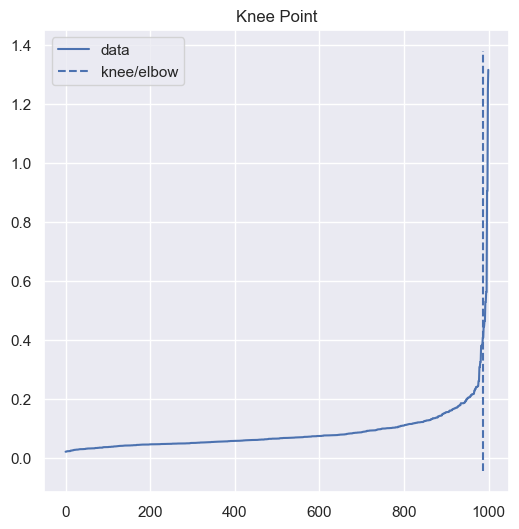

In [29]:
# Identify MinPts
min_pts = X.shape[1] * 2

# Find distances to min_pts'th neighbor
nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X)
distances, _ = nbrs.kneighbors(X)

# Sort the distance to the min_pts'th neighbor
sort_dist = np.sort(distances[:,-1])

kneedle = KneeLocator(
    range(sort_dist.shape[0]), 
    sort_dist, 
    S=1.0, 
    curve="convex", 
    direction="increasing"
)
kneedle.plot_knee()

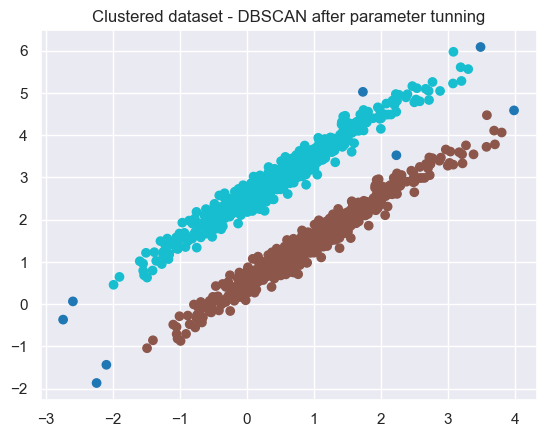

In [30]:
# Cluster again
dbscan_tun = DBSCAN(eps=0.4, min_samples=min_pts)
_ = dbscan_tun.fit(X)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=dbscan_tun.labels_)
plt.title('Clustered dataset - DBSCAN after parameter tunning')
plt.show()

In [31]:
#Silhouette score

In [32]:
silhouette_score(X, kmeans.labels_)

0.4220015714510632

In [33]:
silhouette_score(X, dbscan_tun.labels_)

0.32848328427660817

## DBCV Values 

In [34]:
hdbscan.validity.validity_index(X, dbscan_tun.labels_, metric='euclidean', per_cluster_scores=True)

(0.2298446930421459, array([0.23169828, 0.23169828]))

In [35]:
hdbscan.validity.validity_index(X, kmeans.labels_, metric='euclidean', per_cluster_scores=True)

(-0.811592645944925, array([-0.89650736, -0.74433045]))